# Stock Price Prediction Using LSTM

## Importing necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
from sklearn.metrics import mean_squared_error
import yfinance as yf

In [2]:
# Defining the stock symbol and the date range
stock_symbol = 'AAPL'
end_date = datetime.now()
start_date = datetime(end_date.year-10, end_date.month, end_date.day)

In [3]:
# Fetching the data
data = yf.download(stock_symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [4]:
# Plotting the closing price
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Close'], mode='lines', name='Close Price'))
fig.update_layout(title=f'{stock_symbol} Closing Price', xaxis_title='Date', yaxis_title='Price')
fig.show()

In [5]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-07-07,23.535000,23.997499,23.525000,23.9925,21.222216,225872000
2014-07-08,24.067499,24.200001,23.480000,23.8375,21.085110,260888000
2014-07-09,23.860001,23.987499,23.690001,23.8475,21.093952,145744000
2014-07-10,23.440001,23.887501,23.379999,23.7600,21.016554,158744000
2014-07-11,23.840000,23.972500,23.715000,23.8050,21.056362,136072000


In [6]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,86.169674,87.098194,85.303593,86.238540,84.214229,1.252349e+08
std,59.213429,59.860683,58.626613,59.268820,59.752313,7.187793e+07
min,22.500000,22.917500,22.367500,22.584999,20.585348,2.404830e+07
25%,32.359375,32.642502,32.081876,32.366250,29.166348,7.630292e+07
50%,54.127501,54.834999,53.375000,53.938751,51.592575,1.059684e+08
75%,145.577503,147.315002,144.142502,145.872501,143.948208,1.536372e+08
max,220.000000,221.550003,219.029999,221.550003,221.550003,7.593852e+08


In [7]:
# Preparing the data for LSTM
data_lstm = data[['Close']]

In [8]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_lstm)

In [9]:
# Creating training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [10]:
# Creating the datasets for LSTM
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

In [11]:
time_step = 60
X_train, Y_train = create_dataset(train_data, time_step)
X_test, Y_test = create_dataset(test_data, time_step)

In [12]:
# Reshaping for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## LSTM Model

In [13]:
# Building the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [14]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
# Train the model
model.fit(X_train, Y_train, batch_size=1, epochs=5)

Epoch 1/5
1951/1951 [==============================] - 23s 8ms/step - loss: 8.3972e-04
Epoch 2/5
1951/1951 [==============================] - 15s 8ms/step - loss: 5.6936e-04
Epoch 3/5
1951/1951 [==============================] - 15s 8ms/step - loss: 2.8983e-04
Epoch 4/5
1951/1951 [==============================] - 15s 8ms/step - loss: 3.2662e-04
Epoch 5/5
1951/1951 [==============================] - 15s 8ms/step - loss: 2.1932e-04


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 25)                1275      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31901 (124.61 KB)
Trainable params: 31901 (124.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
# Save the LSTM model
model.save('lstm_stock_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [18]:
# Making predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inversing transform to get actual prices
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
actual_prices = scaler.inverse_transform(scaled_data)

14/14 [==============================] - 0s 4ms/step


## MSE

In [19]:
# Calculating MSE for LSTM
train_mse_lstm = mean_squared_error(scaler.inverse_transform(Y_train.reshape(-1, 1)), train_predict)
test_mse_lstm = mean_squared_error(scaler.inverse_transform(Y_test.reshape(-1, 1)), test_predict)

print(f"Mean Squared Error (MSE) for LSTM:")
print(f"- Training set: {train_mse_lstm:.2f}")
print(f"- Test set: {test_mse_lstm:.2f}")

Mean Squared Error (MSE) for LSTM:
- Training set: 9.95
- Test set: 36.63


In [20]:
# Plotting the predictions
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict

test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(scaled_data) - 1, :] = test_predict

fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=actual_prices[:, 0], mode='lines', name='Actual Prices'))
fig.add_trace(go.Scatter(x=data.index, y=train_predict_plot[:, 0], mode='lines', name='Train Predictions'))
fig.add_trace(go.Scatter(x=data.index, y=test_predict_plot[:, 0], mode='lines', name='Test Predictions'))
fig.update_layout(title=f'{stock_symbol} Price Prediction', xaxis_title='Date', yaxis_title='Price')
fig.show()

# Forecasting using ARIMA Model

In [21]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.4 MB/s eta 0:00:00


In [22]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import pmdarima as pm
import pickle

In [23]:
data = data[['Close']].copy()

## Parameters for ARIMA model

In [24]:
result = adfuller(data.Close.dropna())

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: 0.49819952615619284
p-value: 0.9848182694965554


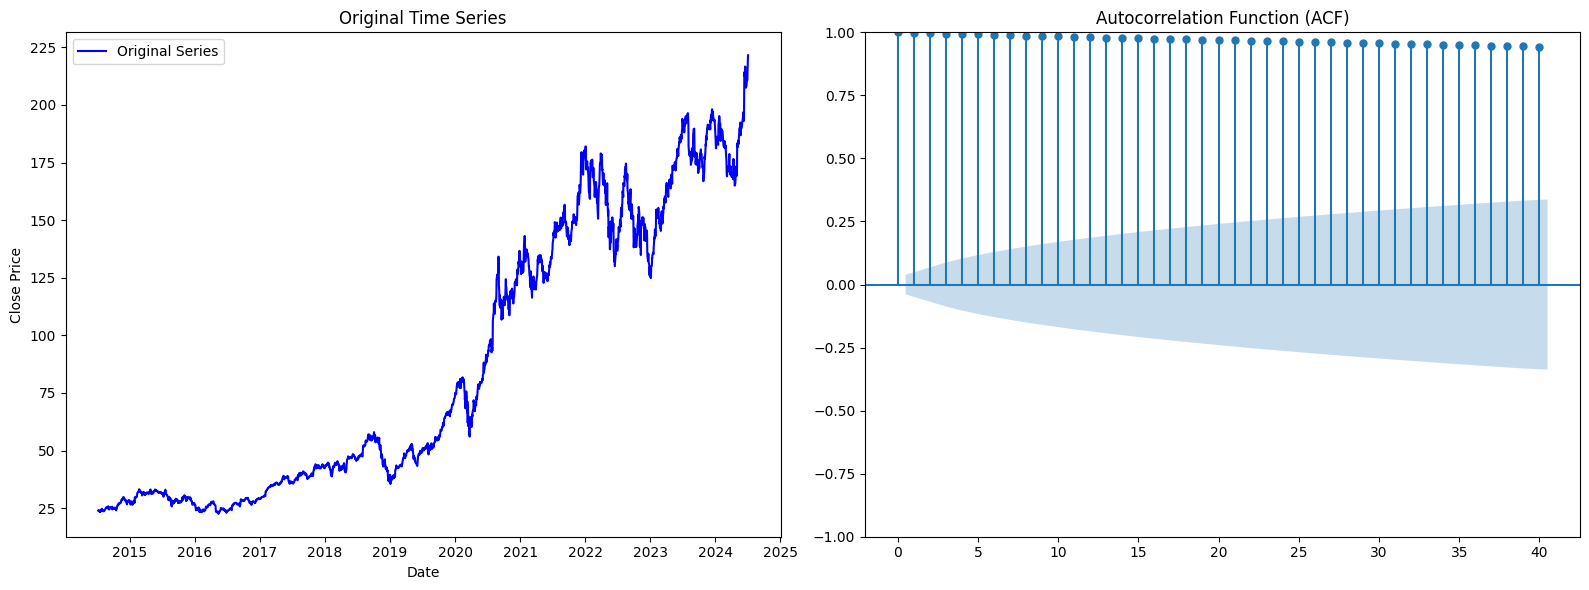

In [25]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Plotting the original time series with Matplotlib
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(data.index, data['Close'], label='Original Series', color='blue')
plt.title('Original Time Series')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# Plotting the Autocorrelation Function (ACF) with Matplotlib
plt.subplot(1, 2, 2)
plot_acf(data['Close'], ax=plt.gca(), title='Autocorrelation Function (ACF)', lags=40)

plt.tight_layout()
plt.show()

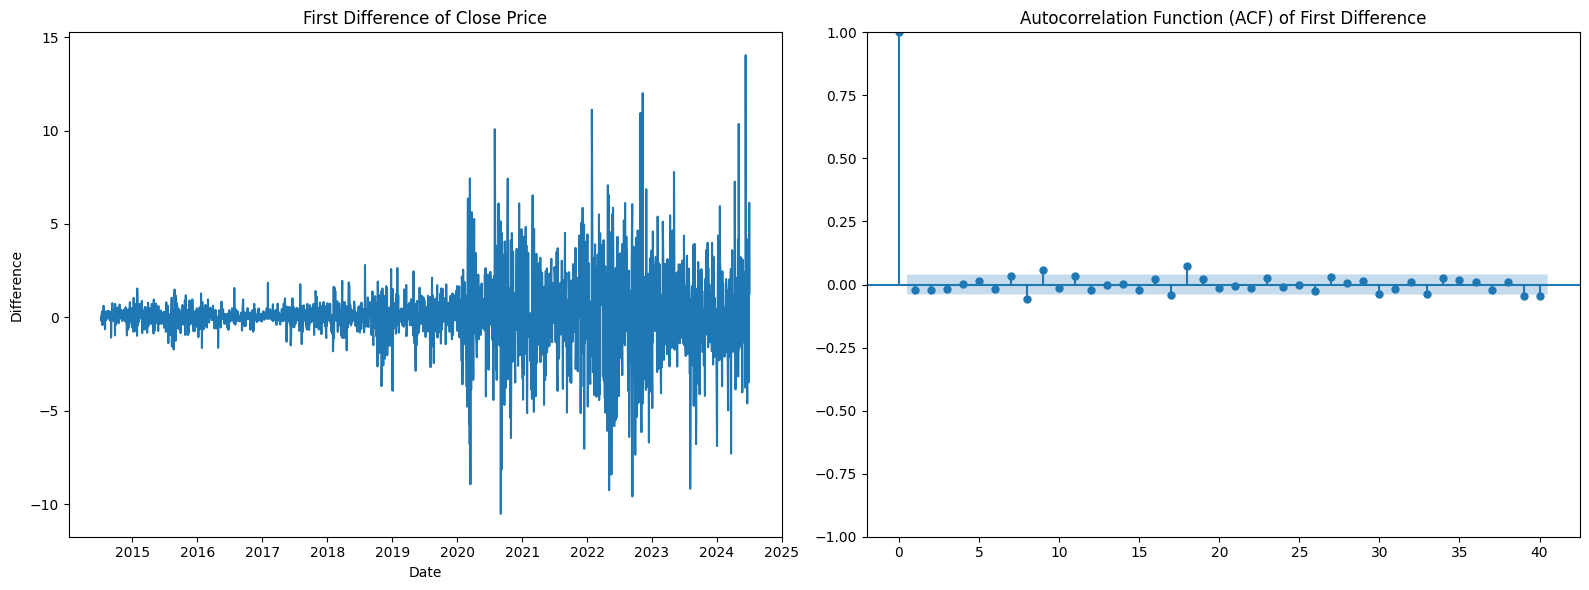

In [26]:
# Calculating first difference
diff1 = data['Close'].diff().dropna()

# Plotting the first difference and its ACF
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plotting first difference
axs[0].plot(diff1)
axs[0].set_title('First Difference of Close Price')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Difference')

# Plotting ACF of first difference
plot_acf(diff1, ax=axs[1], title='Autocorrelation Function (ACF) of First Difference', lags=40)

plt.tight_layout()
plt.show()

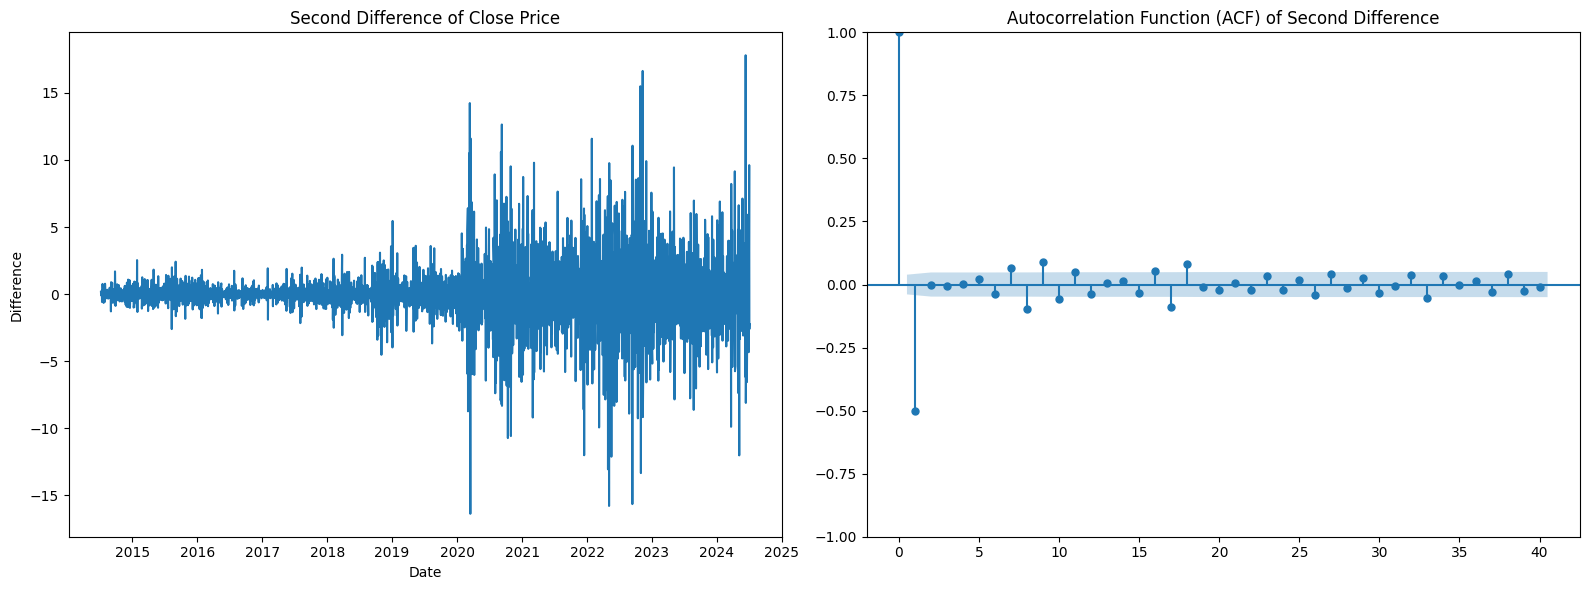

In [27]:
# Calculating second difference
diff2 = data['Close'].diff().diff().dropna()

# Plotting the second difference and its ACF
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plotting second difference
axs[0].plot(diff2)
axs[0].set_title('Second Difference of Close Price')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('Difference')

# Plotting ACF of second difference
plot_acf(diff2, ax=axs[1], title='Autocorrelation Function (ACF) of Second Difference', lags=40)

plt.tight_layout()
plt.show()

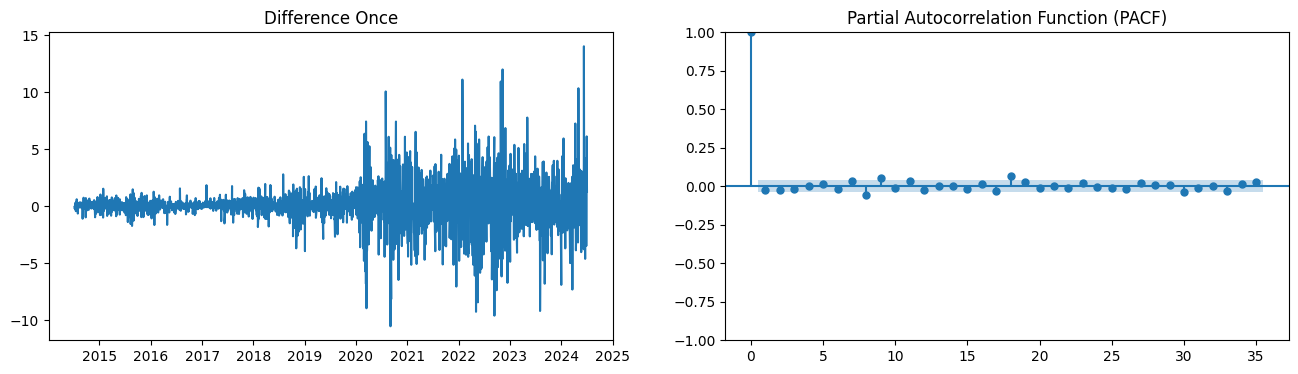

In [28]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

# Compute the first difference
diff = data['Close'].diff().dropna()

# Plotting the first difference with Matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title('Difference Once')

# Plotting the Partial Autocorrelation Function (PACF) with Matplotlib
plot_pacf(diff, ax=ax2, title='Partial Autocorrelation Function (PACF)')
plt.show()

p = 18

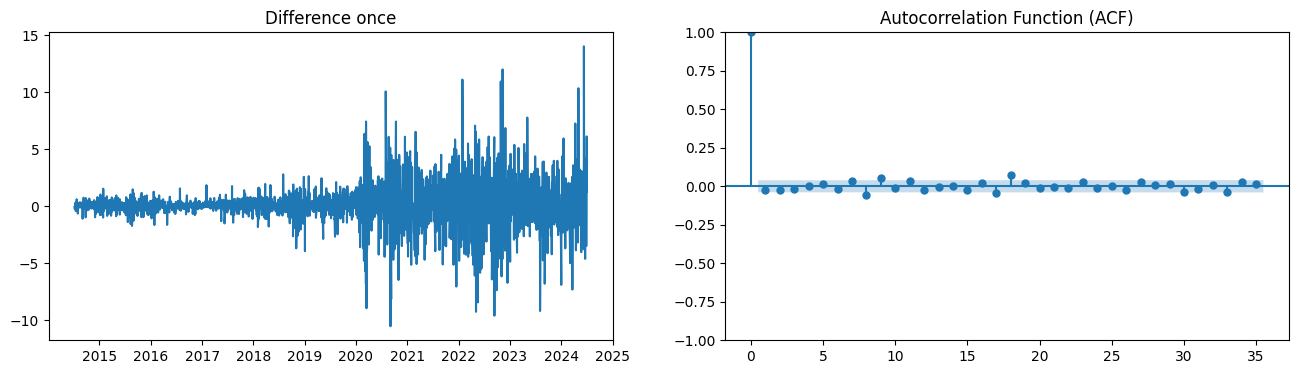

In [29]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Compute the first difference
diff = data['Close'].diff().dropna()

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

# Plotting the first difference
ax1.plot(diff)
ax1.set_title("Difference once")

# Adjust ylim for ACF plot
ax2.set_ylim(0, 1)

# Plotting the Autocorrelation Function (ACF)
plot_acf(diff, ax=ax2, title='Autocorrelation Function (ACF)')

plt.show()

q=9

In [30]:
from pmdarima.arima.utils import ndiffs
from statsmodels.tsa.stattools import adfuller

# Assuming 'data' is your dataframe and 'close' is the column you want to test
close_series = data['Close']

# ADF Test for determining initial differencing
adf_result = adfuller(close_series)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")

# Determine the number of differences needed
diffs = ndiffs(close_series, test='adf')
print(f"Number of Differences: {diffs}")

ADF Statistic: 0.49819952615619284
p-value: 0.9848182694965554
Number of Differences: 1


d = 1

In [31]:
close_series = data['Close']

## ARIMA Model

In [32]:
# Fitting the ARIMA model
model = ARIMA(close_series, order=(18, 1, 9))
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using z

In [33]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2516
Model:                ARIMA(18, 1, 9)   Log Likelihood               -5087.897
Date:                Thu, 04 Jul 2024   AIC                          10231.795
Time:                        17:06:48   BIC                          10395.035
Sample:                             0   HQIC                         10291.041
                               - 2516                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0252      0.195      0.129      0.897      -0.356       0.407
ar.L2          0.1713      0.141      1.213      0.225      -0.106       0.448
ar.L3         -0.2102      0.111     -1.887      0.0

In [36]:
# AIC and BIC scores
aic = model_fit.aic
bic = model_fit.bic

print(f"ARIMA Model Metrics - AIC: {aic:.2f}, BIC: {bic:.2f}")

ARIMA Model Metrics - AIC: 10231.79, BIC: 10395.04


In [37]:
# Save the model to a file using pickle
with open('arima_model.pkl', 'wb') as f:
    pickle.dump(model_fit, f)

In [38]:
# Forecasting
forecast_steps = 100
forecast_values = model_fit.forecast(steps=forecast_steps)

# Constructing forecast dates
forecast_dates = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, freq='D')[1:]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [39]:
# Plotting with Plotly
fig = go.Figure()

# Adding actual prices
fig.add_trace(go.Scatter(x=data.index, y=close_series, mode='lines', name='Actual Prices'))

# Adding forecasted values
fig.add_trace(go.Scatter(x=forecast_dates, y=forecast_values, mode='lines', name='Forecast'))

fig.update_layout(title='ARIMA Forecast for Stock Prices',
                  xaxis_title='Date',
                  yaxis_title='Price',
                  legend=dict(x=0, y=1, traceorder='normal'),
                  plot_bgcolor='rgba(0,0,0,0)')

fig.show()